Incident/Disruption Likelihood Classification

This notebook trains a classifier to predict `Random Event Occurred` (incident/disruption) using the futuristic city traffic dataset.

Outline:
- Load data
- Train/validation split (stratified)
- Preprocessing with ColumnTransformer (OneHotEncode categoricals, pass-through numerics)
- XGBoost (XGBClassifier) with class imbalance handling
- Evaluation: ROC AUC, PR AUC, F1, confusion matrix
- Save trained pipeline


In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, roc_curve, classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump


In [ ]:
# Load data
csv_path = 'futuristic_city_traffic.csv'  # ensure lowercase extension matches filename

df = pd.read_csv(csv_path)
print('Shape:', df.shape)
print(df.head(3))

# Define features and target (avoid leakage)
target_col = 'Random Event Occurred'
leak_cols = ['Traffic Density', 'Energy Consumption']
X = df.drop(columns=[c for c in [target_col] + leak_cols if c in df.columns])
y = df[target_col]


Shape: (1219567, 11)
           City        Vehicle Type      Weather Economic Condition  \
0  SolarisVille               Drone        Snowy             Stable   
1      AquaCity          Flying Car  Solar Flare          Recession   
2     Neuroburg  Autonomous Vehicle  Solar Flare          Recession   

  Day Of Week  Hour Of Day     Speed  Is Peak Hour  Random Event Occurred  \
0      Sunday           20   29.4268             0                      0   
1   Wednesday            2  118.8000             0                      0   
2   Wednesday           16  100.3904             0                      0   

   Energy Consumption  Traffic Density  
0             14.7134           0.5241  
1            143.5682           0.3208  
2             91.2640           0.0415  


In [3]:
# Train/validation split (stratified)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(exclude=['object']).columns.tolist()
print('Categorical:', categorical_cols)
print('Numeric:', numeric_cols)

# Preprocess: One-hot encode categoricals, passthrough numerics
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

# Model: XGBoost classifier; handle class imbalance via scale_pos_weight
pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1]) if y_train.value_counts()[1] > 0 else 1.0
print('scale_pos_weight:', float(pos_weight))

xgb_clf = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist'
)

pipeline = Pipeline([
    ('prep', preprocess),
    ('clf', xgb_clf)
])


Categorical: ['City', 'Vehicle Type', 'Weather', 'Economic Condition', 'Day Of Week']
Numeric: ['Hour Of Day', 'Speed', 'Is Peak Hour']
scale_pos_weight: 19.045055780412138


{'roc_auc': 0.5019633489862252, 'pr_auc': 0.050526278327250235, 'f1': 0.0}

Classification report:
               precision    recall  f1-score   support

           0     0.9501    1.0000    0.9744    231746
           1     0.0000    0.0000    0.0000     12168

    accuracy                         0.9501    243914
   macro avg     0.4751    0.5000    0.4872    243914
weighted avg     0.9027    0.9501    0.9258    243914



C:\Users\ARYAN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ARYAN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ARYAN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

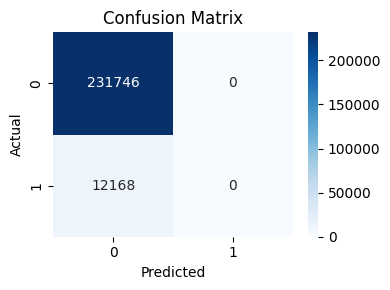

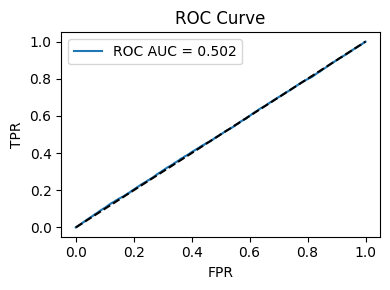

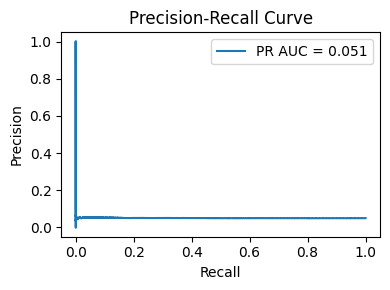

In [4]:
# Fit
pipeline.fit(X_train, y_train)

# Predict
y_val_proba = pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_val, y_val_proba)
pr_auc = average_precision_score(y_val, y_val_proba)
f1 = f1_score(y_val, y_val_pred)
print({'roc_auc': roc_auc, 'pr_auc': pr_auc, 'f1': f1})

print('\nClassification report:\n', classification_report(y_val, y_val_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# PR curve
prec, rec, _ = precision_recall_curve(y_val, y_val_proba)
plt.figure(figsize=(4,3))
plt.plot(rec, prec, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Save pipeline
os.makedirs('Traffic_Model', exist_ok=True)
model_path = os.path.join('Traffic_Model', 'incident_xgb_pipeline.pkl')
dump(pipeline, model_path)
print('Saved:', model_path)


Saved: Traffic_Model\incident_xgb_pipeline.pkl
